In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import keras
from keras.layers import Input, Dense
from keras.models import Model

import innvestigate
import innvestigate.utils as iutils

import numpy as np
import pandas as pd
import time
import os
import pickle

from sklearn import preprocessing
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/bogao/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/bogao/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/bogao/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/bogao/anaconda3/envs/tf/l

### Load data and models

In [3]:
pklfile = '../../data/all_bands.pkl'
with open(pklfile, 'rb') as fi:
    data = pickle.load(fi)
data = preprocessing.MinMaxScaler().fit_transform(np.abs(data))

In [4]:
def loadModel(modelpath):
    return keras.models.load_model(modelpath)

In [5]:
dae_core_1024 = loadModel('../../data/models/model_dae_core_1024.mdl')

In [ ]:
dae_core_2048 = loadModel('../../data/models/model_dae_core_2048.mdl')

In [6]:
input_size = data.shape[1]
idx = 1234

### Plot check

In [11]:
def plotCheck(idx, data, model):

    plt.figure(figsize=(20,5))

    pltrows = 1
    pltcols = 2 

    plt.subplot(pltrows,pltcols, 1)
    plt.title('Original')
    sns.lineplot(x=range(input_size),y=np.abs(data[idx]))


    decoded = model.predict(data[idx].reshape(1,input_size,))
    plt.subplot(pltrows,pltcols, 2)
    plt.title('Decoded')
    sns.lineplot(x=range(input_size),y=decoded[0])


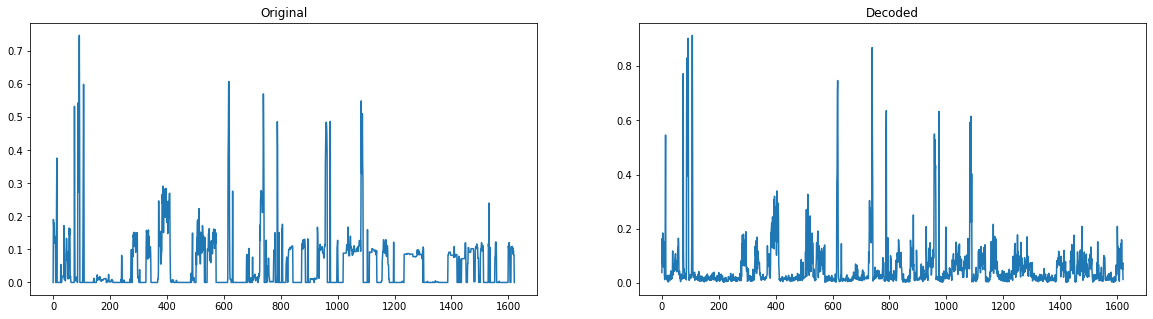

In [12]:
plotCheck(idx, data, dae_core_1024)

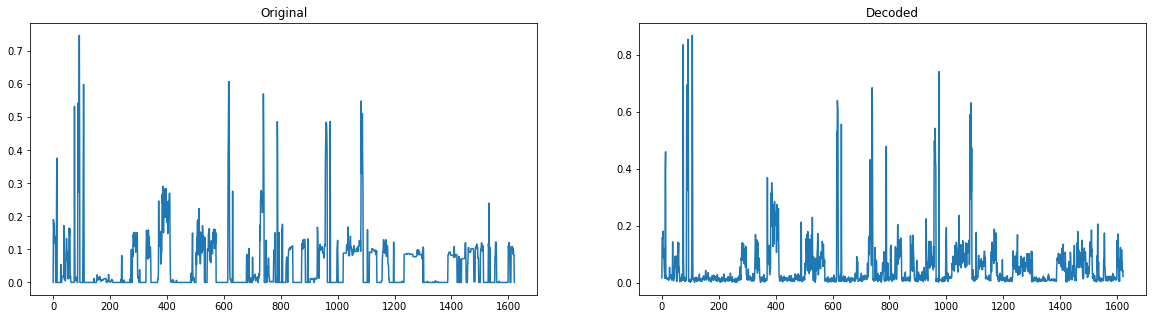

In [14]:
plotCheck(idx, data, dae_core_2048)

### iNNvestigate

In [7]:
encoder = loadModel('../../data/models/encoder_dae_core_1024.mdl')

/Users/bogao/anaconda3/envs/tf/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
x = dae_core_1024.get_layer(index=0).input
h = dae_core_1024.get_layer(index=1).output
encoder = Model(x,h)

In [ ]:
hidden_size = 1024
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", encoder, neuron_selection_mode="index")
i = 0
analysis = np.zeros(input_size)
for neuron_index in range(hidden_size):
    analysis = np.add(analysis, gradient_analyzer.analyze(data, neuron_index))
    i +=1
print(i)

#### analysis contains the summed weights from all hidden neurons

In [157]:
analysis.shape

(42820, 1622)

In [158]:
weightpkl = '../../data/all_bands_weight.pkl'
with open(weightpkl, 'wb') as fo:
    pickle.dump(analysis, fo)

Compare with weighting

In [156]:
analysis.shape

(42820, 1622)

In [10]:
with open('../../data/all_bands_weight.pkl', 'rb') as fi:
    analysis = pickle.load(fi)

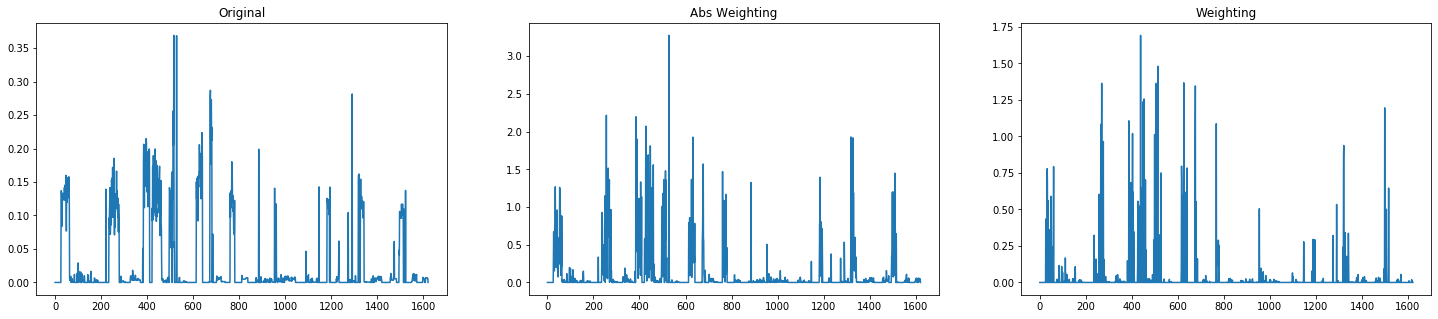

In [11]:
index = 8888
plt.figure(figsize=(25,5))
plt.subplot(1,3, 1)
plt.title('Original')
sns.lineplot(x=range(input_size),y=np.abs(data[index]))

plt.subplot(1,3, 2)
plt.title('Abs Weighting')
sns.lineplot(x=range(input_size),y=np.abs(analysis[index]))

plt.subplot(1,3, 3)
plt.title('Weighting')
sns.lineplot(x=range(input_size),y=np.maximum(analysis[index], 0))

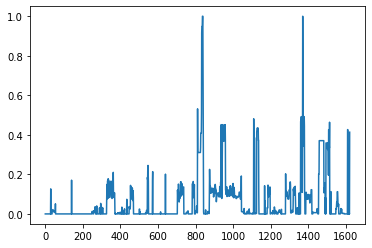

In [19]:
index = 9999
# plt.title('Original')
sns.lineplot(x=range(input_size),y=np.abs(data[index]))

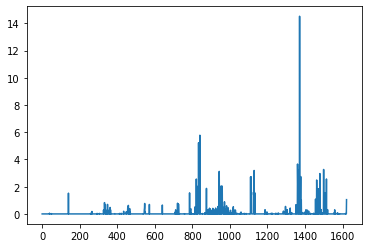

In [20]:
# plt.title('Weighting')
sns.lineplot(x=range(input_size),y=np.maximum(analysis[index], 0))